## Robust Regression

Interested in testing least-squares versus minimizing the absolute deviation. We begin by creating a random linear relationship between x and y, from which we will generate some data.

The true relationship is 0.9776476808621083 + 0.9200568860958009*x


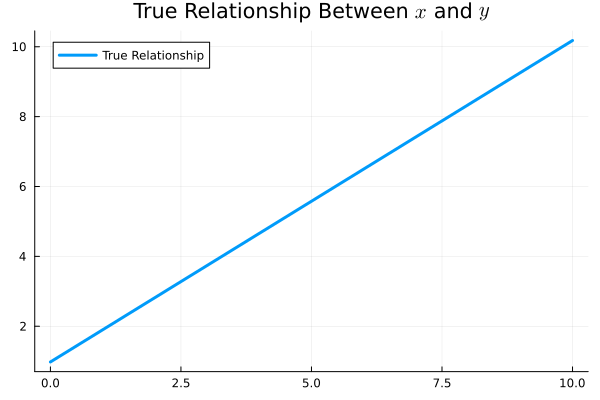

In [12]:
#If you have never used the Random package before
#using Pkg
#Pkg.add("Random")
using Random

#Set the seed of the random number generator so that the results are reproducable
#If you change the number in the parenthesis, the random values below will change
Random.seed!(5)

#Make a random relationship 
βstar = rand(2);

println("The true relationship is ", βstar[1], " + ", βstar[2], "*x")

#The true relationship is \betastar[1] + \betastar[2]*x

#If you have never used the Random package before
#using Pkg
#Pkg.add("Plots")
using Plots
xvals = LinRange(0,10,100);
yvals = βstar[1] .+ βstar[2].*xvals;
plot(xvals,yvals, lw = 3, label = "True Relationship")
title!("True Relationship Between \$x\$ and \$y\$")

Given this relationship, let's generate some data points. To keep it simple, we start with 100 data points which are on this line plus some additive Gaussian noise with mean 0 and variance 1.

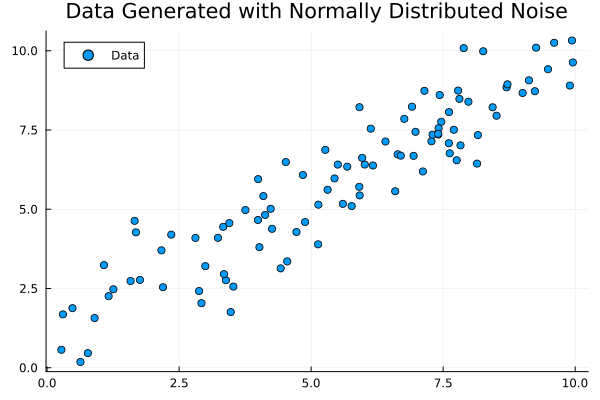

In [13]:
#Let's create some data from this
#Create a 100 length vector x made of numbers uniformly distributed between 0 and 10
x = 10*rand(100)
#ystar is the output with the true relationship.
ystar = βstar[1] .+ βstar[2].*x
#Add normally distributed noise to each sample with mean 0 and variance 1
y = ystar + randn(100)
plot(x, y, seriestype=:scatter, label = "Data")
title!("Data Generated with Normally Distributed Noise")

Now that we have our data, let's see how well least-squares behaves in this situation. This is exactly the setting least-squares is made for, so it should give a  reasonable fit.

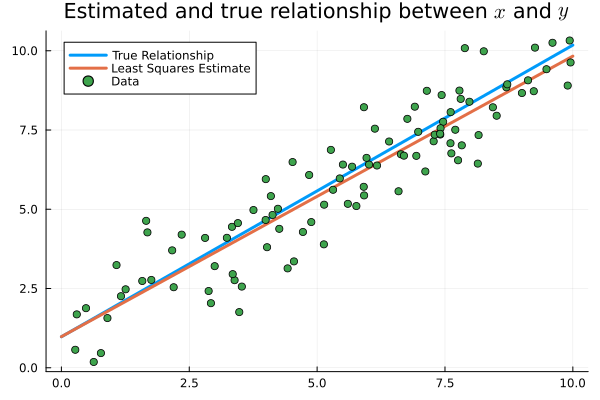

In [14]:
#Let's fit the data to a linear model. To allow for a y-intercept that is not just 0, we can augment the dataset as
xaugmented = hcat(ones(100), x);
#Built in least-squares solution
β = xaugmented\y

yvalsestimated = β[1] .+ β[2].*xvals;
plot(xvals,yvals, lw = 3, label = "True Relationship")
plot!(xvals,yvalsestimated, lw = 3, label = "Least Squares Estimate")
plot!(x, y, seriestype=:scatter, label = "Data")
title!("Estimated and true relationship between \$x\$ and \$y\$")

The predicted fit is pretty accurate to the true relationship!

However, this is mostly because the noise in the problem isn't too bad. What if $y$ is generated differently?

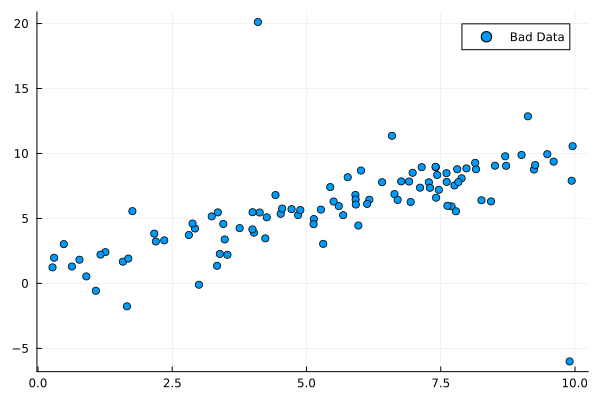

In [15]:
#If you've never used Distributions before
#using Pkg
#Pkg.add("Distributions")

using Distributions
#Standard Cauchy distribution. Particularly pathological and bad
#dist1 = Cauchy()
#ybad = ystar + rand(dist1,100);

#Student's T-Distribution with 2 degrees of freedom. Less bad than Cauchy (T-Dist with 1 degree of freedom)
#and worse than Normal (T-Dist with degrees of freedom -> infinity)
dist2 = TDist(2)
ybad = ystar + rand(dist2,100);

plot(x, ybad, seriestype=:scatter, label = "Bad Data")

Here, we generated data using the Cauchy distribution, which is a pretty pathological example of a distribution (see [text](https://en.wikipedia.org/wiki/Cauchy_distribution) for more details). It created a pretty absurd data set, with one extreme outlier.

Let's try fitting this new data with least-squares.

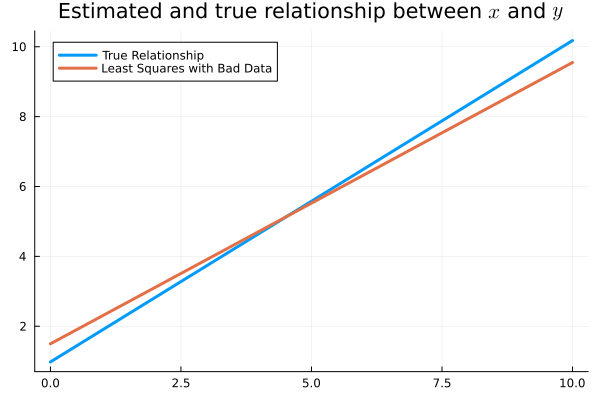

In [16]:
βbad = xaugmented\ybad
ybadestimated = βbad[1] .+ βbad[2].*xvals;
plot(xvals,yvals, lw = 3, label = "True Relationship")
plot!(xvals,ybadestimated, lw = 3, label = "Least Squares with Bad Data")
#plot!(x, ybad, seriestype=:scatter, label = "Bad Data")
title!("Estimated and true relationship between \$x\$ and \$y\$")

That single massive outlier destroyed the least-squares fit. Let's reformulate using by minimizing the absolute deviations, i.e.

$$\underset{\beta \in \mathbb{R}^n}{\min} \quad \frac{1}{m}\sum_{i=1}^m |x_i^T \beta - y_i|.$$

We reformulate this as an LP by introducing $m$ variables $t_i$ and using the epigraph transformation:

\begin{align*}
\underset{\beta \in \mathbb{R}^n, t \in \mathbb{R}^m}{\min} \quad &\frac{1}{m}\sum_{i=1}^m t_i \\
\text{subject to} \quad &t_i \geq x_i^T \beta - y_i \\
& t_i \geq - x_i^T \beta + y_i.
\end{align*}

In [17]:
using JuMP
using HiGHS

regression = Model(HiGHS.Optimizer)
@variable(regression, βlp[1:2])
@variable(regression, t[1:100])
@constraint(regression, tpositive[i in 1:100], t[i] >= βlp[1] + βlp[2]*x[i] - ybad[i])
@constraint(regression, tnegative[i in 1:100], t[i] >= -βlp[1] - βlp[2]*x[i] + ybad[i])
@objective(regression, Min, sum(t[i] for i in 1:100))

#print(regression)
latex_formulation(regression)

$$ \begin{aligned}
\min\quad & t_{1} + t_{2} + t_{3} + t_{4} + t_{5} + t_{6} + t_{7} + t_{8} + t_{9} + t_{10} + t_{11} + t_{12} + t_{13} + t_{14} + t_{15} + t_{16} + t_{17} + t_{18} + t_{19} + t_{20} + t_{21} + t_{22} + t_{23} + t_{24} + t_{25} + t_{26} + t_{27} + t_{28} + t_{29} + t_{30} + [[\ldots\text{40 terms omitted}\ldots]] + t_{71} + t_{72} + t_{73} + t_{74} + t_{75} + t_{76} + t_{77} + t_{78} + t_{79} + t_{80} + t_{81} + t_{82} + t_{83} + t_{84} + t_{85} + t_{86} + t_{87} + t_{88} + t_{89} + t_{90} + t_{91} + t_{92} + t_{93} + t_{94} + t_{95} + t_{96} + t_{97} + t_{98} + t_{99} + t_{100}\\
\text{Subject to} \quad & -βlp_{1} - 8.70050607316552 βlp_{2} + t_{1} \geq -9.781074105402288\\
 & -βlp_{1} - 4.23354361278987 βlp_{2} + t_{2} \geq -3.465003004547409\\
 & -βlp_{1} - 4.520441932313954 βlp_{2} + t_{3} \geq -5.35307571044896\\
 & -βlp_{1} - 9.938435069453979 βlp_{2} + t_{4} \geq -7.900551871072848\\
 & -βlp_{1} - 7.888326559680227 βlp_{2} + t_{5} \geq -8.091147046583806\\
 & -β

In [18]:
optimize!(regression)

Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
200 rows, 102 cols, 600 nonzeros
200 rows, 102 cols, 600 nonzeros
Presolve : Reductions: rows 200(-0); columns 102(-0); elements 600(-0) - Not reduced
Problem not reduced by presolve: solving the LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -1.7650000000e+05 Ph1: 200(425322); Du: 100(176.5) 0s
        155     1.2808610069e+02 Pr: 0(0) 0s
Model   status      : Optimal
Simplex   iterations: 155
Objective value     :  1.2808610069e+02
HiGHS run time      :          0.00


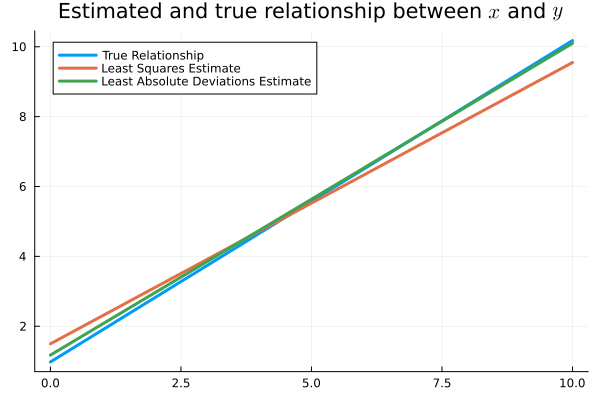

In [19]:
βabsolute = value.(βlp)
yabsoluteestimated =  βabsolute[1] .+ βabsolute[2].*xvals;

plot(xvals,yvals, lw = 3, label = "True Relationship")
plot!(xvals,ybadestimated, lw = 3, label = "Least Squares Estimate")
plot!(xvals,yabsoluteestimated, lw = 3, label = "Least Absolute Deviations Estimate")
#plot!(x, ybad, seriestype=:scatter, label = "Bad Data")
title!("Estimated and true relationship between \$x\$ and \$y\$")